In [10]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn.utils import resample
import skimage.measure
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange
from scipy.interpolate import interp1d

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3.0


np.random.seed(1942)

# 1. Bias Variance Tradeoff - Bootstrapping
Here we explore bias variance tradeoff, using bootstrapping. This enables us to actually put numbers on the bias and variance.

In [2]:
def bias_variance_bootstrap(solver, poly_orders, nr_bootstraps=100, lamda=1e-4, nr_averages=1):
    """Function calculating train and test error (MSE) for a series of polyomial orders.
       Input:
            solver - "OLS", "Ridge", or "Lasso". Type of solver to be used.
            poly_orders - array of polynomial orders to run for.
            nr_averages - How many times to run the thing and average over.
            lambda - optional lambda for Ridge and Lasso
        Returns:
            error_list - array with length of poly_orders, with testing data MSE of each polynomial order.
            bias_list - array with length of poly_orders, model bias of each polynomial order.
            var_list - array with length of poly_orders, with model variance of each polynomial order.
    """
    error_list = np.zeros(len(poly_orders))
    bias_list = np.zeros(len(poly_orders))
    var_list = np.zeros(len(poly_orders))

    for i in range(nr_averages):
        x_train, x_test, y_train, y_test, output_train, output_test = train_test_split(reg.x_flat, reg.y_flat, reg.f_flat, test_size = 0.25)

        for j in trange(len(poly_orders)):
            poly_order = poly_orders[j]
            X_test = reg.get_X(x_test, y_test, poly_order=poly_order)
            output_pred = np.zeros((nr_bootstraps, output_test.shape[0]))
            for i in range(nr_bootstraps):
                x_, y_, output_ = resample(x_train, y_train, output_train)
                X_ = reg.get_X(x_, y_, poly_order=poly_order)
                if solver == "OLS" or solver == "OLS_unsafe" or solver == "Ridge":
                    beta = reg.get_beta(X_, output_, solver=solver, lamda=lamda)
                elif solver == "Lasso":
                    _Lasso = Lasso(alpha=lamda, fit_intercept=False, max_iter=1e8, tol=1e-3)
                    clf = _Lasso.fit(X_, output_)
                    beta = clf.coef_
                output_pred[i] = X_test@beta

            error = np.mean( np.mean((output_test - output_pred)**2, axis=0, keepdims=True) )
            bias = np.mean( (output_test - np.mean(output_pred, axis=0, keepdims=True))**2 )
            var = np.mean( np.var(output_pred, axis=0, keepdims=True) )

            error_list[j] += error
            bias_list[j] += bias
            var_list[j] += var
    error_list /= nr_averages
    bias_list /= nr_averages
    var_list /= nr_averages
    
    return error_list, bias_list, var_list

## 1.1 Franke Data

In [21]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

In [22]:
poly_orders = np.arange(0, 25, 1)

In [6]:
error_list_OLS, bias_list_OLS, var_list_OLS = bias_variance_bootstrap("OLS", poly_orders, nr_averages=10)

100%|██████████| 25/25 [03:18<00:00, 19.23s/it]


In [6]:
error_list_Ridge4, bias_list_Ridge4, var_list_Ridge4 = bias_variance_bootstrap("Ridge", poly_orders, lamda=1e-4, nr_averages=10)

100%|██████████| 25/25 [03:11<00:00, 17.65s/it]


In [8]:
error_list_Lasso4, bias_list_Lasso4, var_list_Lasso4 = bias_variance_bootstrap("Lasso", poly_orders, lamda=1e-4, nr_averages=1)

100%|██████████| 25/25 [51:45<00:00, 279.38s/it]


In [23]:
np.save("../data/error_list_OLS.npy", error_list_OLS)  # To avoid having to run time consuming code all the time, we save the results to file.
np.save("../data/bias_list_OLS.npy", bias_list_OLS)
np.save("../data/var_list_OLS.npy", var_list_OLS)
np.save("../data/error_list_Ridge4.npy", error_list_Ridge4)
np.save("../data/bias_list_Ridge4.npy", bias_list_Ridge4)
np.save("../data/var_list_Ridge4.npy", var_list_Ridge4)
np.save("../data/error_list_Lasso4.npy", error_list_Lasso4)
np.save("../data/bias_list_Lasso4.npy", bias_list_Lasso4)
np.save("../data/var_list_Lasso4.npy", var_list_Lasso4)

min_poly = 1
end_poly = 20

error_list_OLS = np.load("../data/error_list_OLS.npy")[min_poly:end_poly]
bias_list_OLS = np.load("../data/bias_list_OLS.npy")[min_poly:end_poly]
var_list_OLS = np.load("../data/var_list_OLS.npy")[min_poly:end_poly]
error_list_Ridge4 = np.load("../data/error_list_Ridge4.npy")[min_poly:end_poly]
bias_list_Ridge4 = np.load("../data/bias_list_Ridge4.npy")[min_poly:end_poly]
var_list_Ridge4 = np.load("../data/var_list_Ridge4.npy")[min_poly:end_poly]
error_list_Lasso4 = np.load("../data/error_list_Lasso4.npy")[min_poly:end_poly]
bias_list_Lasso4 = np.load("../data/bias_list_Lasso4.npy")[min_poly:end_poly]
var_list_Lasso4 = np.load("../data/var_list_Lasso4.npy")[min_poly:end_poly]

poly_orders = poly_orders[min_poly:end_poly]

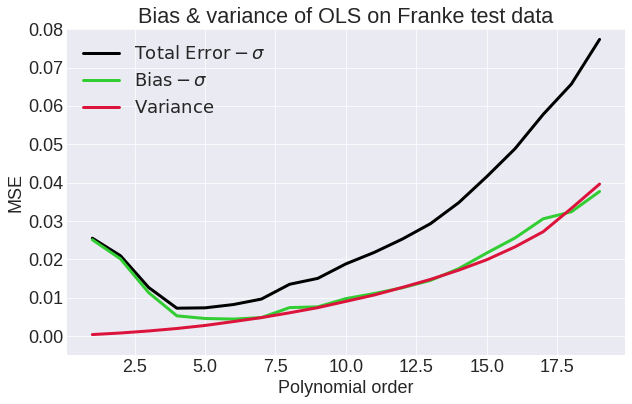

In [29]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders, error_list_OLS-1, label="$\mathrm{Total\ Error} - \sigma$", c="black")
plt.plot(poly_orders, bias_list_OLS-1, label="$\mathrm{Bias} - \sigma$", c="limegreen")
plt.plot(poly_orders, var_list_OLS, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.title("Bias & variance of OLS on Franke test data")
plt.ylim(-0.005, 0.08)
plt.legend()
plt.savefig("../figs/BV_bootstrap_Franke_OLS.pdf", bbox_inches="tight");

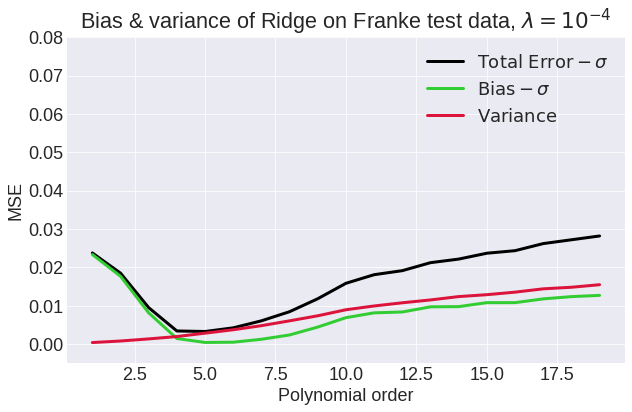

In [30]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders, error_list_Ridge4-1, label="$\mathrm{Total\ Error} - \sigma$", c="black")
plt.plot(poly_orders, bias_list_Ridge4-1, label="$\mathrm{Bias} - \sigma$", c="limegreen")
plt.plot(poly_orders, var_list_Ridge4, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.title("Bias & variance of Ridge on Franke test data, $\lambda=10^{-4}$")
plt.ylim(-0.005, 0.08)
plt.legend()
plt.savefig("../figs/BV_bootstrap_Franke_Ridge.pdf", bbox_inches="tight");

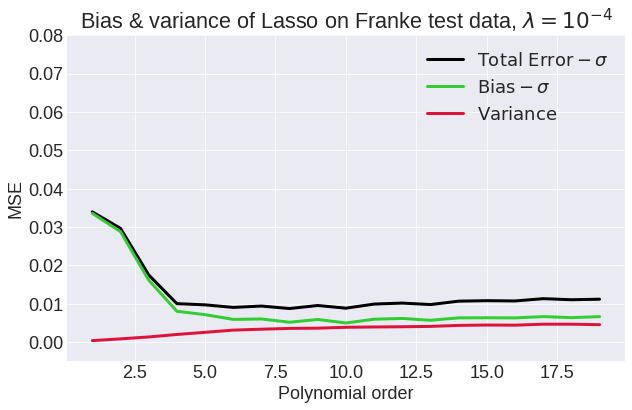

In [31]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders, error_list_Lasso4-1, label="$\mathrm{Total\ Error} - \sigma$", c="black")
plt.plot(poly_orders, bias_list_Lasso4-1, label="$\mathrm{Bias} - \sigma$", c="limegreen")
plt.plot(poly_orders, var_list_Lasso4, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.ylim(-0.005, 0.08)
plt.title("Bias & variance of Lasso on Franke test data, $\lambda=10^{-4}$")
plt.legend()
plt.savefig("../figs/BV_bootstrap_Franke_Lasso.pdf", bbox_inches="tight");

## 1.2 Terrain Data

In [32]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain1 = skimage.measure.block_reduce(terrain0, (32, 32), np.mean)
reg = Regression()
reg.load_matrix_data(terrain1); terrain1.shape

(113, 57)

In [33]:
poly_orders_T = np.arange(0, 40, 1)

In [13]:
error_list_OLS_T, bias_list_OLS_T, var_list_OLS_T = bias_variance_bootstrap("OLS", poly_orders_T, nr_averages=10)

100%|██████████| 40/40 [09:40<00:00, 40.68s/it]


In [14]:
error_list_Ridge4_T, bias_list_Ridge4_T, var_list_Ridge4_T = bias_variance_bootstrap("Ridge", poly_orders_T, lamda=1e-4, nr_averages=10)

100%|██████████| 40/40 [09:47<00:00, 40.94s/it]


In [15]:
error_list_Lasso4_T, bias_list_Lasso4_T, var_list_Lasso4_T = bias_variance_bootstrap("Lasso", poly_orders_T, lamda=1e-4)

100%|██████████| 40/40 [32:39<00:00, 113.46s/it]


In [34]:
np.save("../data/error_list_OLS_T.npy", error_list_OLS_T)
np.save("../data/bias_list_OLS_T.npy", bias_list_OLS_T)
np.save("../data/var_list_OLS_T.npy", var_list_OLS_T)
np.save("../data/error_list_Ridge4_T.npy", error_list_Ridge4_T)
np.save("../data/bias_list_Ridge4_T.npy", bias_list_Ridge4_T)
np.save("../data/var_list_Ridge4_T.npy", var_list_Ridge4_T)
np.save("../data/error_list_Lasso4_T.npy", error_list_Lasso4_T)
np.save("../data/bias_list_Lasso4_T.npy", bias_list_Lasso4_T)
np.save("../data/var_list_Lasso4_T.npy", var_list_Lasso4_T)

min_poly = 1
max_poly = 28
error_list_OLS_T = np.load("../data/error_list_OLS_T.npy")[min_poly:max_poly]
bias_list_OLS_T = np.load("../data/bias_list_OLS_T.npy")[min_poly:max_poly]
var_list_OLS_T = np.load("../data/var_list_OLS_T.npy")[min_poly:max_poly]
error_list_Ridge4_T = np.load("../data/error_list_Ridge4_T.npy")[min_poly:max_poly]
bias_list_Ridge4_T = np.load("../data/bias_list_Ridge4_T.npy")[min_poly:max_poly]
var_list_Ridge4_T = np.load("../data/var_list_Ridge4_T.npy")[min_poly:max_poly]
error_list_Lasso4_T = np.load("../data/error_list_Lasso4_T.npy")[min_poly:max_poly]
bias_list_Lasso4_T = np.load("../data/bias_list_Lasso4_T.npy")[min_poly:max_poly]
var_list_Lasso4_T = np.load("../data/var_list_Lasso4_T.npy")[min_poly:max_poly]

poly_orders_T = np.arange(min_poly, max_poly, 1)

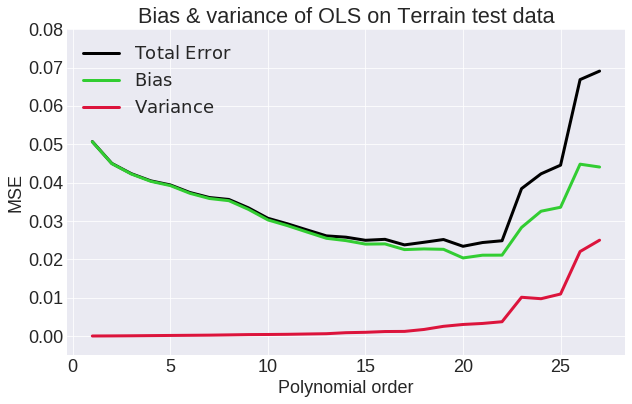

In [35]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders_T, error_list_OLS_T, label="$\mathrm{Total\ Error}$", c="black")
plt.plot(poly_orders_T, bias_list_OLS_T, label="$\mathrm{Bias}$", c="limegreen")
plt.plot(poly_orders_T, var_list_OLS_T, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.title("Bias & variance of OLS on Terrain test data")
plt.ylim(-0.005, 0.08)
plt.legend()
plt.savefig("../figs/BV_bootstrap_Terrain_OLS.pdf", bbox_inches="tight");

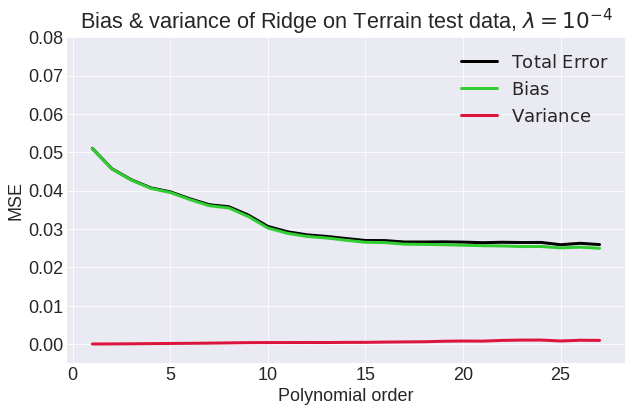

In [36]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders_T, error_list_Ridge4_T, label="$\mathrm{Total\ Error}$", c="black")
plt.plot(poly_orders_T, bias_list_Ridge4_T, label="$\mathrm{Bias}$", c="limegreen")
plt.plot(poly_orders_T, var_list_Ridge4_T, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.title("Bias & variance of Ridge on Terrain test data, $\lambda = 10^{-4}$")
plt.ylim(-0.005, 0.08)
plt.legend()
plt.savefig("../figs/BV_bootstrap_Terrain_Ridge.pdf", bbox_inches="tight");

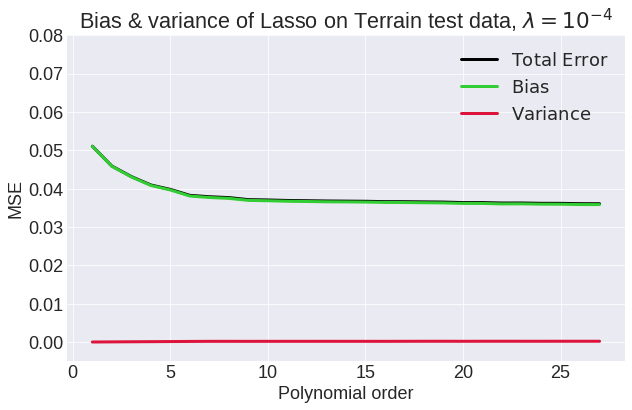

In [37]:
plt.figure(figsize=(10,6))
plt.plot(poly_orders_T, error_list_Lasso4_T, label="$\mathrm{Total\ Error}$", c="black")
plt.plot(poly_orders_T, bias_list_Lasso4_T, label="$\mathrm{Bias}$", c="limegreen")
plt.plot(poly_orders_T, var_list_Lasso4_T, label="$\mathrm{Variance}$", c="crimson")
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.title("Bias & variance of Lasso on Terrain test data, $\lambda=10^{-4}$")
plt.ylim(-0.005, 0.08)
plt.legend()
plt.savefig("../figs/BV_bootstrap_Terrain_Lasso.pdf", bbox_inches="tight");